# Advertizement Investment and Sales Prediction

This aims to develop a regression model with PyTorch to predict sales from three forms of advetizement. The data is obtained from [kaggle](https://www.kaggle.com/datasets/ashydv/advertising-dataset)

In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(42)

In [41]:
data = pd.read_csv('advertising.csv')
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


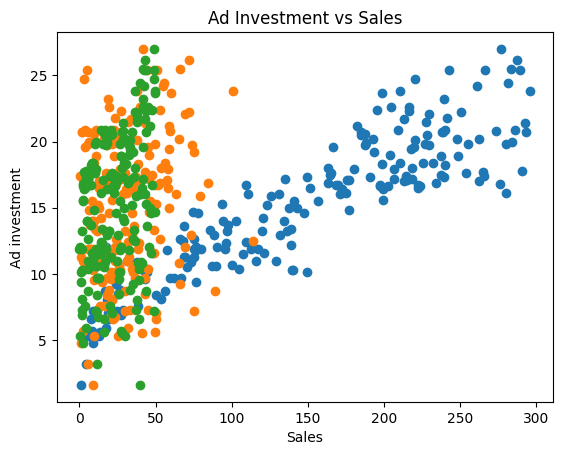

(None,)

In [45]:
plt.scatter(data['TV'], data['Sales'])
plt.scatter(data['Newspaper'], data['Sales'])
plt.scatter(data['Radio'], data['Sales'])
plt.title('Ad Investment vs Sales')
plt.xlabel('Sales')
plt.ylabel('Ad investment')
plt.show(),

In [49]:
class MLP(nn.Module):
  def __init__(self, num_in, num_hidden, num_out):
    super().__init__()
    self.l1 = nn.Linear(num_in, num_hidden)
    self.l2 = nn.Linear(num_hidden, num_out)

  def forward(self, x):
    x = self.l2(F.relu(self.l1(x)))

    return x


In [51]:
X_train, X_val, y_train, y_val = train_test_split(data[['TV', 'Radio','Newspaper']], data['Sales'], test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

# initial parameters
epochs = 50
batch_size =  16
n_batches = np.ceil(len(X_train)/batch_size).astype(int)

early_stopping = 5
train_losses = []
val_losses = []

best_val_loss = float('inf')
# to prevent overfitting
min_improve = 1.0
no_improve = 0

# model, model parameters
num_in = 3
num_hidden = 20
num_out = 1
model = MLP(num_in, num_hidden, num_out)

# optimizer
learning_rate = 0.001
opt = optim.SGD(model.parameters(), lr = learning_rate)



for epoch in range(epochs):
  running_loss = 0
  shuffled_indices = np.random.permutation(len(X_train))

  for batch in range(n_batches):

    start = batch * batch_size
    end = start + batch_size
    batch_indices = shuffled_indices[start:end]

    X = X_train[batch_indices, :]
    y = y_train[batch_indices, :]

    opt.zero_grad()
    y_preds = model(X)
    loss = F.mse_loss(y, y_preds)
    running_loss += loss.item()

    # update parameters
    loss.backward()
    opt.step()

  # validation
  with torch.no_grad():
    y_preds_val = model(X_val)
    val_loss = F.mse_loss(y_val, y_preds_val)

  # log
  train_losses.append(running_loss/len(X))
  val_losses.append(val_loss/len(X))

  # early stop checkpoint
  if (val_losses[-1] < best_val_loss) & (np.abs(val_losses[-1] - best_val_loss) > min_improve):
      """
        To avoid overfitting, set the expected minimum improvement value (by default = 1.0).
        This is unusual to implement this and (val_losses[-1] < best_val_loss) will be enough.
      """

      best_val_loss = val_losses[-1]
      no_improve = 0
  else:
      no_improve += 1

  if early_stopping and no_improve >= early_stopping:
      print('Stopping early')
      break

  print(f'epoch : {epoch+1}, train loss : {running_loss/len(X):.4f}, val loss : {val_loss: .2f}')


update val_loss
epoch : 1, train loss : 154.6796, val loss :  204.27
update val_loss
epoch : 2, train loss : 135.1065, val loss :  173.08
update val_loss
epoch : 3, train loss : 113.7249, val loss :  138.34
update val_loss
epoch : 4, train loss : 89.7430, val loss :  101.05
update val_loss
epoch : 5, train loss : 64.5562, val loss :  65.64
update val_loss
epoch : 6, train loss : 41.5463, val loss :  37.35
update val_loss
epoch : 7, train loss : 23.9359, val loss :  19.35
epoch : 8, train loss : 12.8863, val loss :  9.98
epoch : 9, train loss : 7.0588, val loss :  5.97
epoch : 10, train loss : 4.3440, val loss :  4.48
epoch : 11, train loss : 3.1605, val loss :  4.02
Stopping early


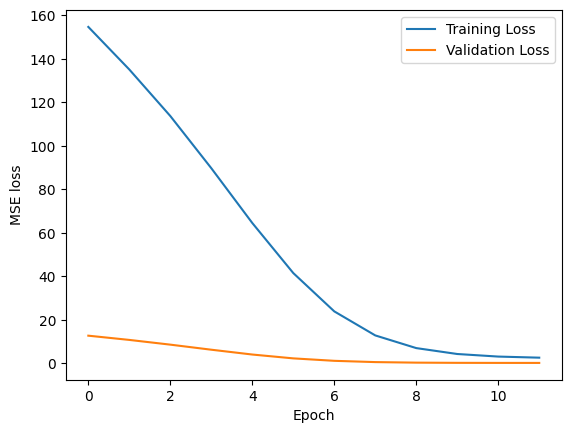

In [52]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [39]:
model.eval()
with torch.no_grad():
  val_pred = model(X_val)

val_pred_np = val_pred.numpy()
y_val_np = y_val.numpy()

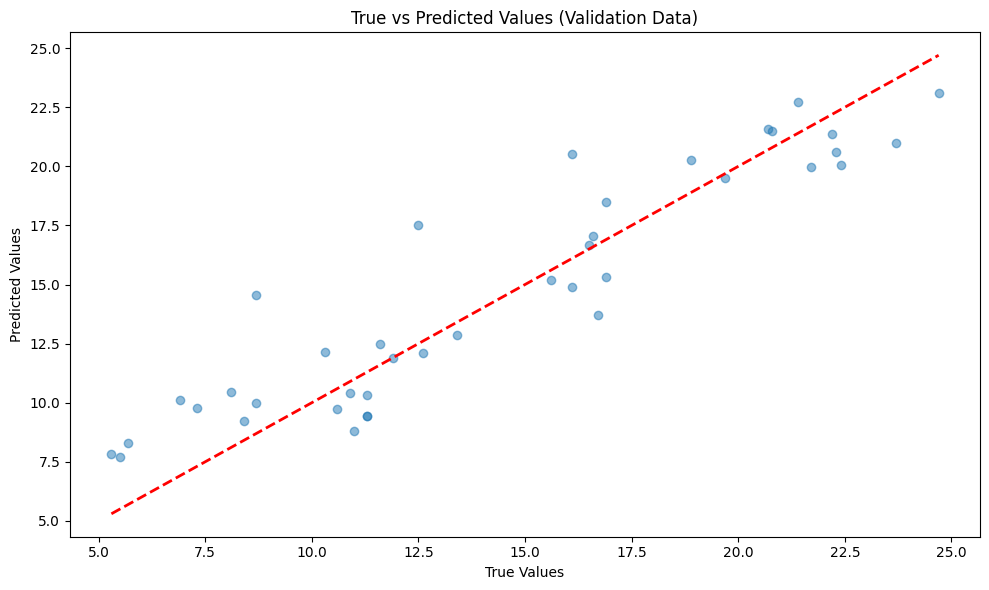

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val_np, val_pred_np, alpha=0.5)
plt.plot([y_val_np.min(), y_val_np.max()], [y_val_np.min(), y_val_np.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Validation Data)')
plt.tight_layout()
plt.show()